<a href="https://colab.research.google.com/github/dayekb/Study/blob/main/rus/UrFU/%D0%98%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5%20%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%20%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B%20%D0%B8%20%D1%82%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B8%20%D0%B2%20%D0%BC%D0%B5%D0%B4%D0%B8%D1%86%D0%B8%D0%BD%D0%B5/2%20%D1%81%D0%B5%D0%B7%D0%BE%D0%BD/%D0%91%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D1%8B%20(ipynb)/ML_2_10_2_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт Библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
plt.style.use('dark_background')

Наша визуализация 4 пространств из предыдущих блокнотов

In [ ]:
def plot_multi(data, y,  names):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    fig, sub = plt.subplots(2, 2, figsize = (11,11))

    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = 25, cmap = 'tab10',alpha = 0.5 );
        ax.set_ylabel(label[1])
        ax.set_xlabel(label[0])
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Numbers")
        ax.add_artist(legend1)

# Загружаем данные

Все тот же MNIST


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


# Создаем Класс Автокодировщик

Здесь представлен относительно простой вариант - Полносвязная Нейронная Сеть


Количество и размерность слоев задаются списками **encoder_dims** и **decoder_dims**

In [ ]:
class Autoencoder(Model):
  def __init__(self, encoder_dims,decoder_dims):
    super(Autoencoder, self).__init__()
    self.encoder_dims = encoder_dims  
    self.decoder_dims = decoder_dims

    # Экодер 
    # Слой Выпрямления 
    self.encoder = tf.keras.Sequential([layers.Flatten(), ])
    # Полносвязные слои с функцией активации ReLU
    for e_dim in encoder_dims:
        self.encoder.add(layers.Dense(e_dim, activation='relu'))  
    
    # Декодер 
    self.decoder = tf.keras.Sequential()
    # Полносвязные слои с функцией активации ReLU
    for d_dim in decoder_dims:
        self.decoder.add(layers.Dense(d_dim, activation='relu'))
    # Слой с количеством нейронов как в Выпрямленном изображении и функцией Активации Сигмоида 
    self.decoder.add (layers.Dense(784, activation='sigmoid'))
    # Слой сворачивающий столбец обратно в картинку 
    self.decoder.add (layers.Reshape((28, 28)))
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

**Создаем Модель**



*   encoder_dims - список из размерностей слоев Энкодера + Скрытое Представление
*   decoder_dims - список из размерностей слоев Декодера




In [ ]:
encoder_dims = [256, 32, 4]
decoder_dims = [32, 256]

autoencoder = Autoencoder(encoder_dims,decoder_dims)


**Компилируем Модель**

Оптимизатор Adam, потому что "он популярный"

Потери - MSE, потому что хотим восстанавливать исходное

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.build(input_shape = (None, 28, 28))
autoencoder.summary();

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4)                 209316    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            210096    
                                                                 
Total params: 419,412
Trainable params: 419,412
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.encoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 209,316
Trainable params: 209,316
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                160       
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 210,096
Trainable params: 210,096
Non-trainable params: 0
_________________________________________________________________


**Обучаем Модель**

стандартный **.fit** 

Обращаем внимание, что **входные данные** и **ожидаемый ответ** это одно и тоже 

In [ ]:
tf.random.set_seed(1234)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 256

In [ ]:
from datetime import datetime

# дата
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')


log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# тут можно подкрутить ранную остановку

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

# Важно! - у нас достаточно "кастомная" нейронка. Поэтому мы  save_weights_only = True
# Иначе он будет ругаться
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min',
    save_weights_only = True
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=EPOCHS,
                batch_size = BATCH_SIZE,
                shuffle=True,    
                callbacks=cb,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 8s 30ms/step - loss: 0.0717 - val_loss: 0.0516
Epoch 2/100
235/235 [==============================] - 9s 37ms/step - loss: 0.0462 - val_loss: 0.0417
Epoch 3/100
235/235 [==============================] - 9s 37ms/step - loss: 0.0402 - val_loss: 0.0384
Epoch 4/100
235/235 [==============================] - 5s 20ms/step - loss: 0.0375 - val_loss: 0.0363
Epoch 5/100
235/235 [==============================] - 5s 20ms/step - loss: 0.0358 - val_loss: 0.0351
Epoch 6/100
235/235 [==============================] - 5s 20ms/step - loss: 0.0347 - val_loss: 0.0342
Epoch 7/100
235/235 [==============================] - 5s 19ms/step - loss: 0.0340 - val_loss: 0.0337
Epoch 8/100
235/235 [==============================] - 5s 20ms/step - loss: 0.0334 - val_loss: 0.0332
Epoch 9/100
235/235 [==============================] - 5s 20ms/step - loss: 0.0329 - val_loss: 0.0327
Epoch 10/100
235/235 [==============================] - 5s 20ms/step - loss: 0.032

# Посмотрим, как это все работает в итоге

Посмотрим что получается на выходе **Энкодера** и **Декодера** 

На **тренировочных** данных

In [ ]:
encoded_imgs_train = autoencoder.encoder(x_train).numpy()
decoded_imgs_train = autoencoder.decoder(encoded_imgs_train).numpy()

Визуализируем первые 10 картинок

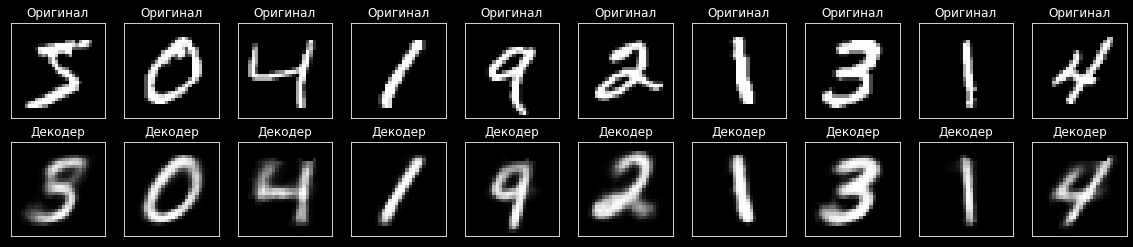

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("Оригинал")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_train[i])
  plt.title("Декодер")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Визуализируем выход **Энкодера**

In [ ]:
ae_names = ['AE-'+str(x+1) for x in range(4)]

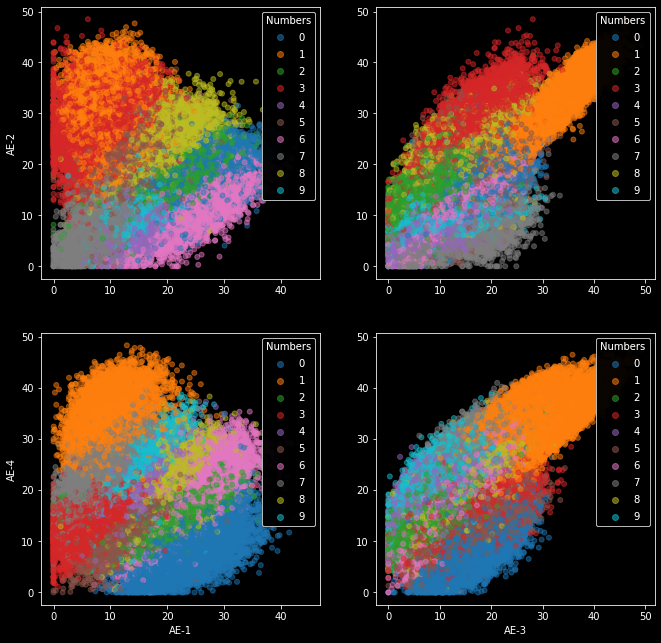

In [ ]:
plot_multi(encoded_imgs_train, y_train, ae_names)

На **тестовых** данных

In [ ]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs_test = autoencoder.decoder(encoded_imgs_test).numpy()

Визуализируем первые 10 картинок

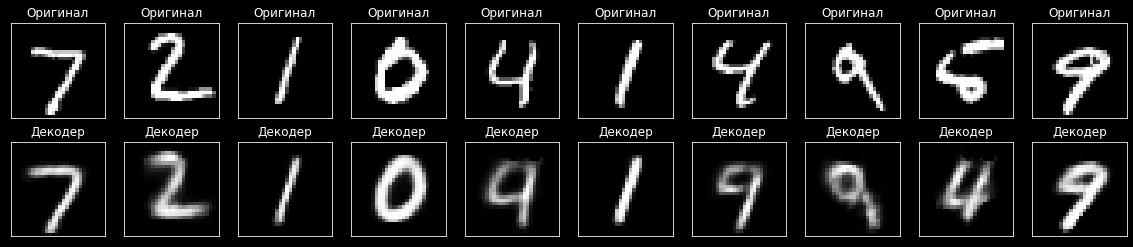

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("Оригинал")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_test[i])
  plt.title("Декодер")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Визуализируем выход **Энкодера**

In [ ]:
ae_names = ['AE-'+str(x+1) for x in range(4)]

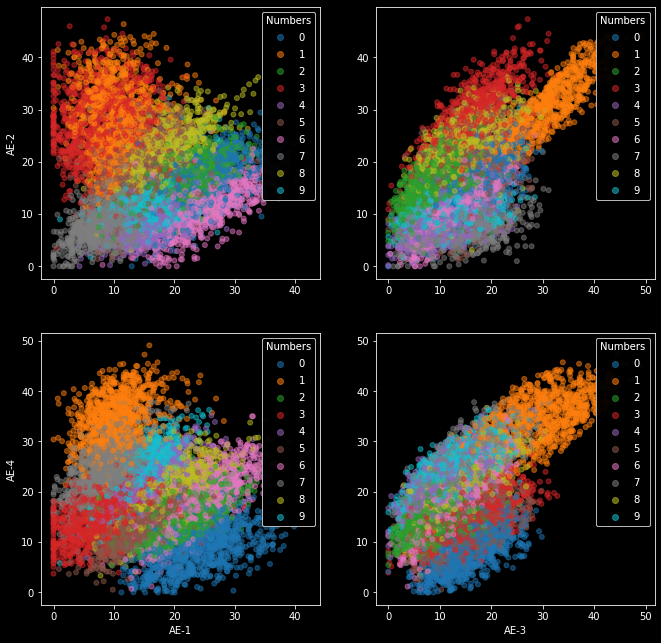

In [ ]:
plot_multi(encoded_imgs_test, y_test, ae_names)

# Как это можно использовать для поиска аномалий

In [ ]:
noise_factor = 0.25

In [ ]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
encoded_imgs_test_noisy = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs_test_noisy = autoencoder.decoder(encoded_imgs_test_noisy).numpy()

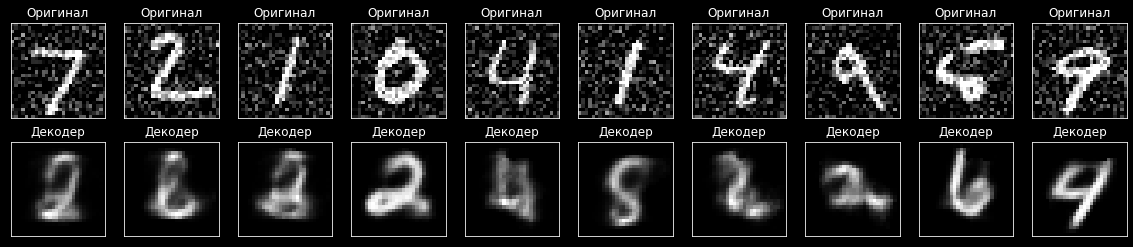

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i])
  plt.title("Оригинал")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_test_noisy[i])
  plt.title("Декодер")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

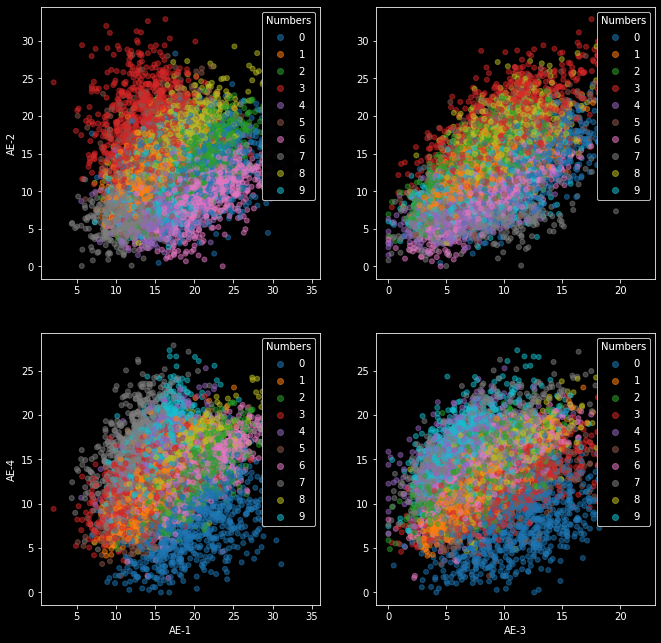

In [ ]:
plot_multi(encoded_imgs_test_noisy, y_test, ae_names)

In [ ]:
mse_noisy = np.mean(np.mean(np.power(x_test_noisy - decoded_imgs_test_noisy, 2),axis = 1),axis = 1)
mse = np.mean(np.mean(np.power(x_test - decoded_imgs_test, 2),axis = 1),axis = 1)

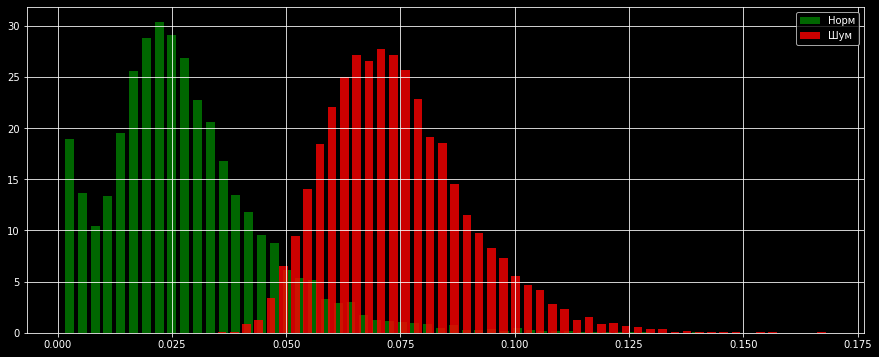

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

ax.hist(mse, bins=50, density=True, label="Норм", alpha=.8, color="green", rwidth=0.7)
ax.hist(mse_noisy, bins=50, density=True, label="Шум", alpha=.8, color="red", rwidth=0.7)
plt.legend()
plt.grid();

# Как потом запустить модель

1. Создаем модель заново
2. Обучаем на хотя бы 1-м изображении 
3. Загружаем веса

In [ ]:
encoder_dims = [256, 32, 4]
decoder_dims = [32, 256]

loaded_model = Autoencoder(encoder_dims,decoder_dims)
loaded_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
loaded_model.train_on_batch(x_train[:1], y_train[:1])
loaded_model.load_weights('autoencoder_best_weights.hdf5')

In [ ]:
encoded_imgs_test = loaded_model.encoder(x_test).numpy()
decoded_imgs_test = loaded_model.decoder(encoded_imgs_test).numpy()

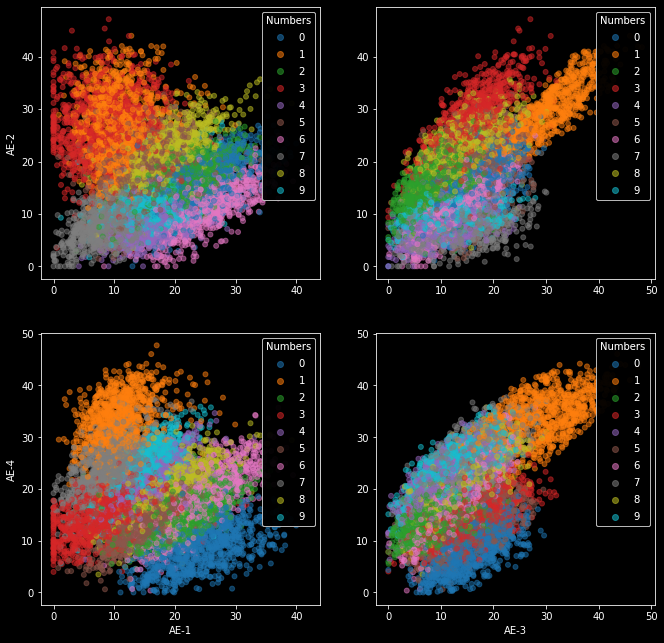

In [ ]:
plot_multi(encoded_imgs_test, y_test, ae_names)